## Google Colab Setup


In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the "project" folder

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'A5'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['a5_helper.py', 'two_digit_op.json', 'eecs598', '__pycache__', 'lstmattn_model.pt', 'transformer_helper.py', 'transformer.pt', 'Transformers.ipynb', 'rnn_lstm_captioning.py', 'inference.ipynb', 'lstm.pt', 'rnn.pt', 'attn.pt', 'rnn_lstm_captioning.ipynb']


In [4]:
import torch
import os
from a5_helper import decode_captions
import matplotlib.pyplot as plt
from eecs598.utils import attention_visualizer, reset_seed

# for plotting
%matplotlib inline
plt.style.use("seaborn")  # Prettier plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 24
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

<ipython-input-4-ab3123432c4f>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")  # Prettier plots


In [5]:
if torch.cuda.is_available():
    print("Cuda available!")
    DEVICE = torch.device("cuda")
else:
    print("Using CPU")
    DEVICE = torch.device("cpu")

Cuda available!


## 1. Download and Prepare Data

In [6]:
from a5_helper import load_coco_captions

# Download and load serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (IMAGE_SHAPE)
# "val_images" - resized validation images (IMAGE_SHAPE)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"

if os.path.isfile("./datasets/coco.pt"):
    print("COCO data exists!")
else:
    print("downloading COCO dataset")
    !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt -P ./datasets/

# load COCO data from coco.pt, loaf_COCO is implemented in a5_helper.py
data_dict = load_coco_captions(path="./datasets/coco.pt")

num_train = data_dict["train_images"].size(0)
num_val = data_dict["val_images"].size(0)

# declare variables for special tokens
NULL_index = data_dict["vocab"]["token_to_idx"]["<NULL>"]
START_index = data_dict["vocab"]["token_to_idx"]["<START>"]
END_index = data_dict["vocab"]["token_to_idx"]["<END>"]
UNK_index = data_dict["vocab"]["token_to_idx"]["<UNK>"]

downloading COCO dataset
--2024-05-12 04:20:38--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396583632 (378M)
Saving to: ‘./datasets/coco.pt’

coco.pt             100%[===================>] 378.21M  47.4MB/s    in 8.3s    

2024-05-12 04:20:47 (45.7 MB/s) - ‘./datasets/coco.pt’ saved [396583632/396583632]

train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])

Train images shape:  torch.Size([10000, 3, 112, 112])
Train caption tokens shape:  torch.Size(

## 2. Initialize Model and Load Weights

In [7]:
from rnn_lstm_captioning import CaptioningRNN

In [38]:
MODEL_MODES = ['rnn','lstm','attn']
# CHANGE MODE HERE TO SWITCH TO OTHER MODELS
MODE = 'lstm'

In [39]:
# Create the image captioning model.
if MODE in MODEL_MODES:
  model = CaptioningRNN(
      cell_type=MODE,
      word_to_idx=data_dict["vocab"]["token_to_idx"],
      input_dim=400,  # hard-coded, do not modify
      hidden_dim=512,
      wordvec_dim=256,
      ignore_index=NULL_index,
  )
  model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH,f'models/{MODE}.pt')))
  model = model.to(DEVICE)
else:
  print('Value for MODE can only be an item of MODEL_MODES')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


For input images in NCHW format, shape (2, 3, 112, 112)
Shape of output c5 features: torch.Size([2, 400, 4, 4])


## 3. Inference and Visualization

In [40]:
# Batch size used for visualization:
VIS_BATCH_SIZE = 4

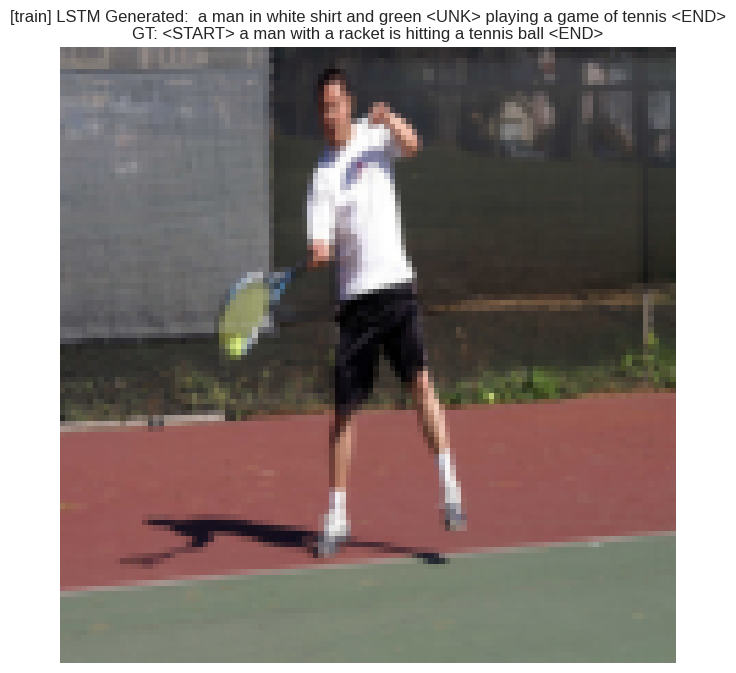

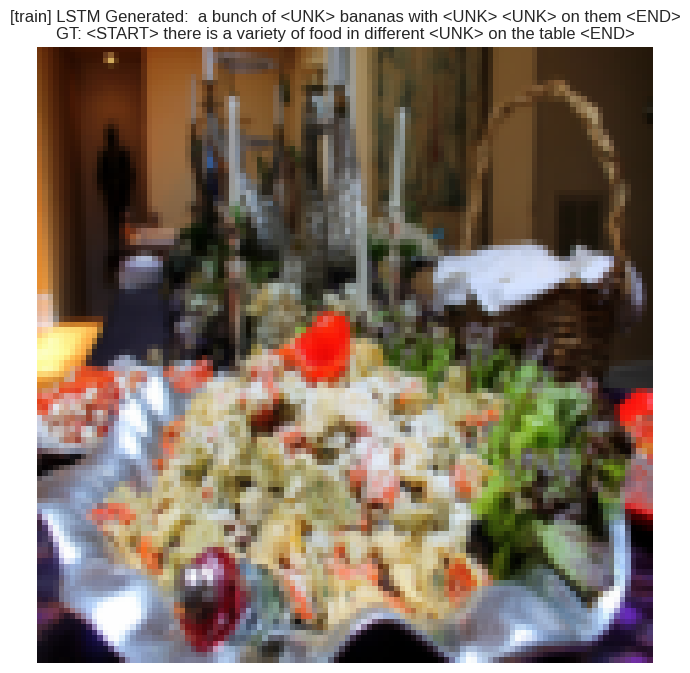

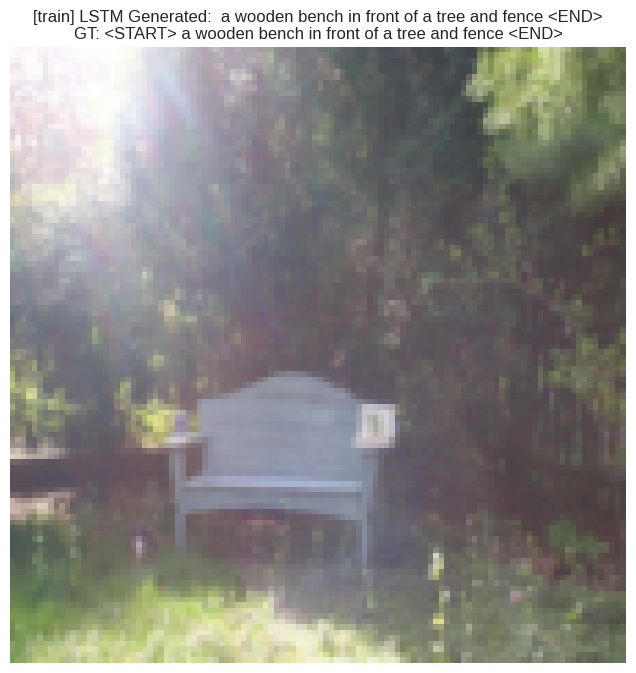

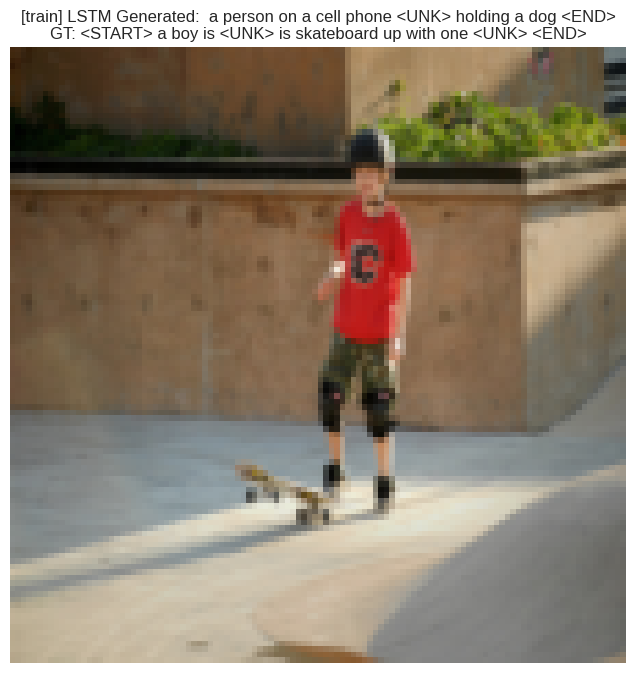

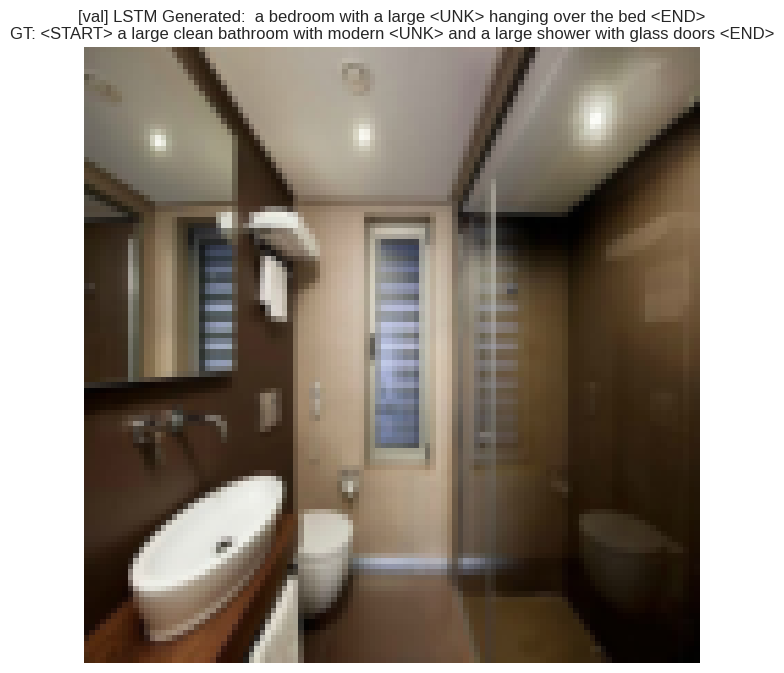

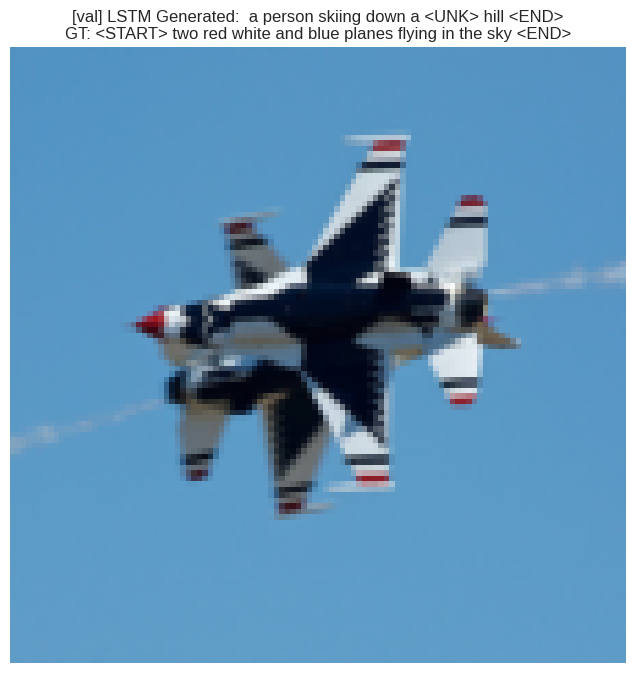

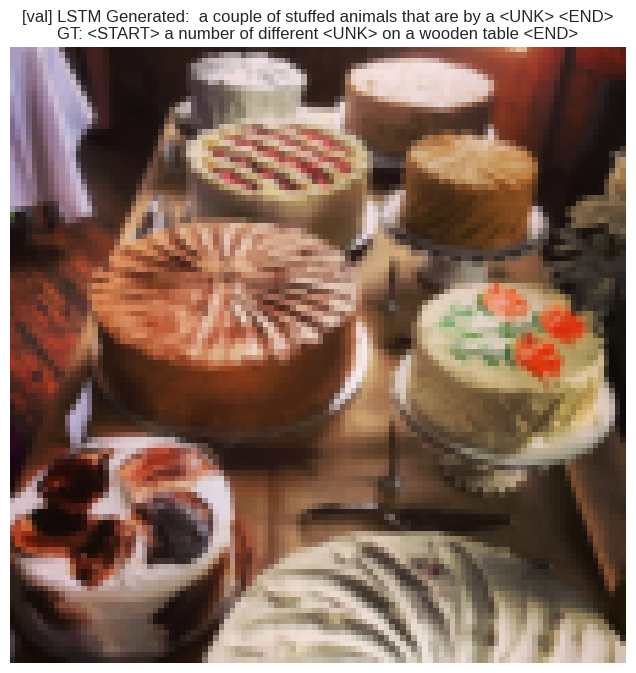

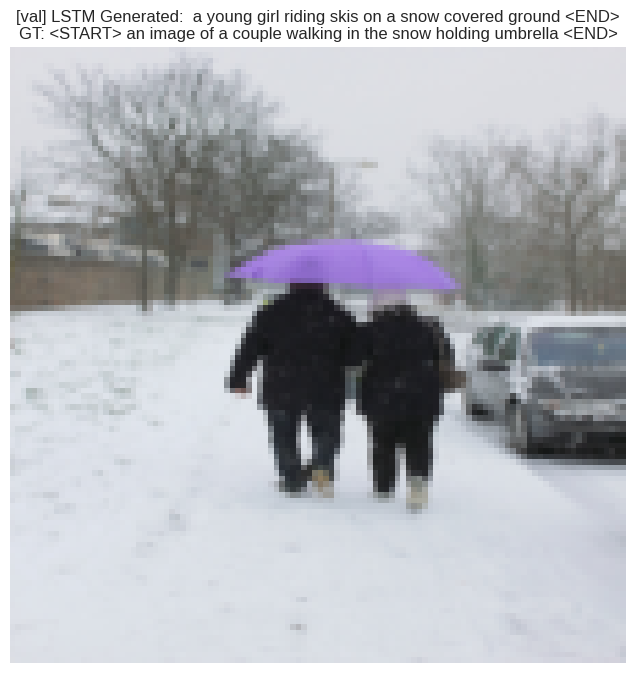

In [43]:
model.eval()

for split in ["train", "val"]:
    sample_idx = torch.randint(
        0, num_train if split == "train" else num_val, (VIS_BATCH_SIZE,)
    )
    sample_images = data_dict[split + "_images"][sample_idx]
    sample_captions = data_dict[split + "_captions"][sample_idx]

    # decode_captions is loaded from a5_helper.py
    gt_captions = decode_captions(sample_captions, data_dict["vocab"]["idx_to_token"])
    if MODE == 'attn':
      generated_captions,_ = model.sample(sample_images.to(DEVICE))
    else:
      generated_captions = model.sample(sample_images.to(DEVICE))
    generated_captions = decode_captions(
        generated_captions, data_dict["vocab"]["idx_to_token"]
    )
    plot_title = f'{MODE.upper()} Generated: '
    for i in range(VIS_BATCH_SIZE):
        plt.imshow(sample_images[i].permute(1, 2, 0))
        plt.axis("off")
        plt.title(
            f"[{split}] {plot_title} {generated_captions[i]}\nGT: {gt_captions[i]}"
        )
        plt.show()